Here I have two things:

- list of moments from donuts premade and measured
- some new set of coordinates against which to test moment generation

TODO:

- redo donut creation for fixed rzero, x, and y. This should make the zernike relation more clear
- then remake (at same z values) for different rzero, different x and y. See if that changes things

In [1]:
%matplotlib inline

In [106]:
moment_data = pd.read_csv('/Users/cpd/Projects/WavefrontPSF/meshes/interpolated_zernikes.csv', index_col=0)
moment_data['one_over_rzero'] = 1. / moment_data['rzero']
# generate interpolation scheme from this. Start with kNN because I'm lazy
from WavefrontPSF.psf_interpolator import kNN_Interpolator
# first test without x, y coordinates
moment_interpolator = kNN_Interpolator(moment_data, y_keys=['e0', 'e1', 'e2', 'delta1', 'delta2', 'zeta1', 'zeta2'],
                                       x_keys=['z{0}'.format(i) for i in range(4, 12)] +
                                              ['one_over_rzero'])

In [123]:
from WavefrontPSF.decamutil import decaminfo
def generate_random_coordinates(number):
    x = np.random.random(number) * 2048
    y = np.random.random(number) * 4096
    available = [i for i in xrange(63) if i != 61]
    extnum = np.random.choice(available, size=number, replace=True)
    x, y = decaminfo().getPosition_extnum(extnum, x, y)
    return x, y, extnum

In [126]:
# generate zernikes and measure moments with this
from WavefrontPSF.donutengine import DECAM_Model_Wavefront
project_dir = '/Users/cpd/Projects/WavefrontPSF'
# test instantiation of donutengine wavefront
knn_data = pd.read_csv(project_dir + '/meshes/ComboMeshes2/Mesh_Science-20140212s2-v1i2_All_train.csv', index_col=0)
WF = DECAM_Model_Wavefront(PSF_Interpolator_data=knn_data)

In [127]:
number = 1000
x, y, extnum = generate_random_coordinates(number)
data = pd.DataFrame({'x': x, 'y': y, 'ext': extnum})
data['rzero'] = 0.14
data['one_over_rzero'] = 1. / data['rzero']
# get zernikes
data = WF.PSF_Interpolator(data)
# measure moments
psf_eval = WF(data)


In [85]:
stamps = []
for i, row in data.iterrows():
    inputZernikeArray = WF.PSF_Drawer.convert_zernike_floats_to_array(row)
    rzero = row['rzero']
    if np.all(inputZernikeArray):
        print('Warning! All zernikes in row {0} are missing or equal to zero!'.format(i))
    x = row['x']
    y = row['y']
    stamp = WF.PSF_Drawer.make_donut.make(inputZernikeArray=inputZernikeArray,
                                 rzero=rzero,
                                 nEle=1e0,
                                 background=0,
                                 xDECam=x,
                                 yDECam=y).astype(np.float64)
    stamps.append(stamp)
stamps = np.array(stamps)
evaluated_psfs = WF.PSF_Evaluator(stamps)
combined_df = evaluated_psfs.combine_first(data)

(<matplotlib.figure.Figure at 0x12e8caed0>,
 <matplotlib.axes.AxesSubplot at 0x12f4095d0>)

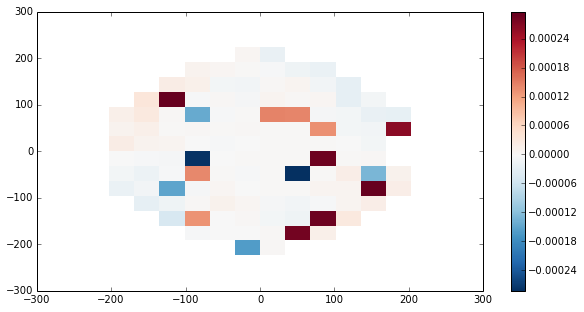

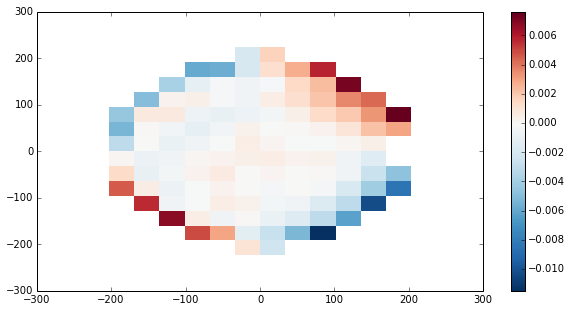

In [92]:
WF.plot_colormap(psf_eval, 'x', 'y', 'e2', num_bins=1)
WF.plot_colormap(combined_df, 'x', 'y', 'e2', num_bins=1)

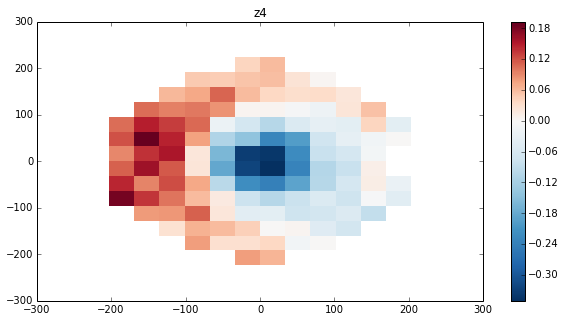

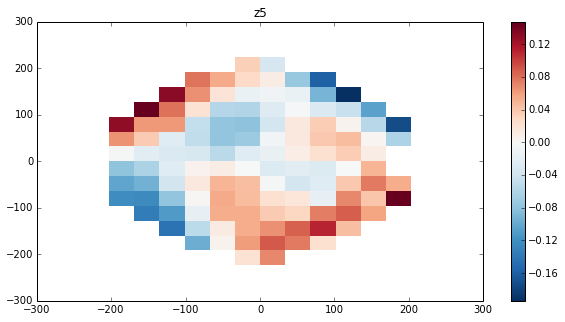

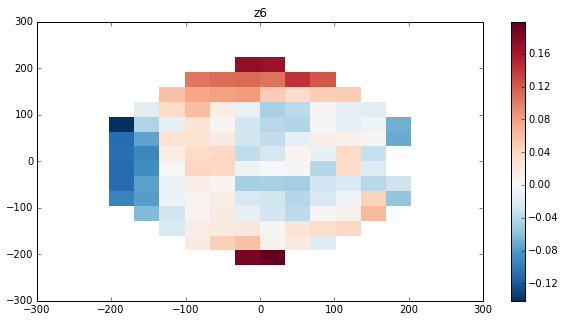

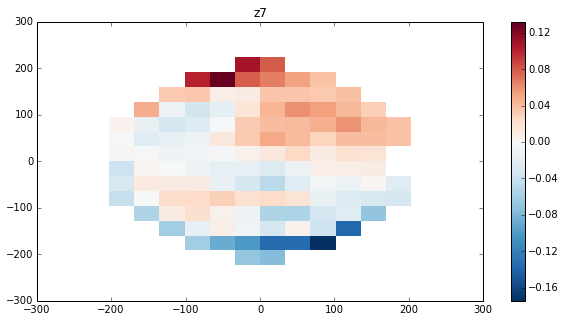

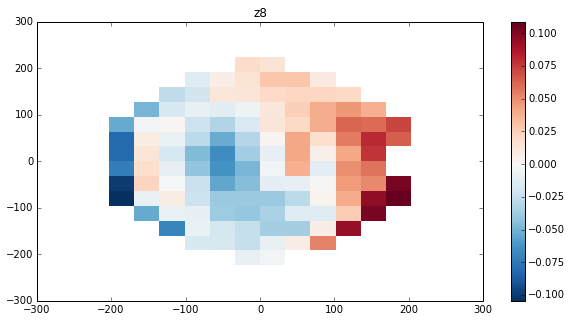

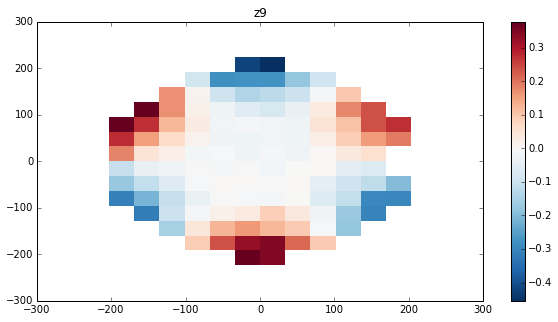

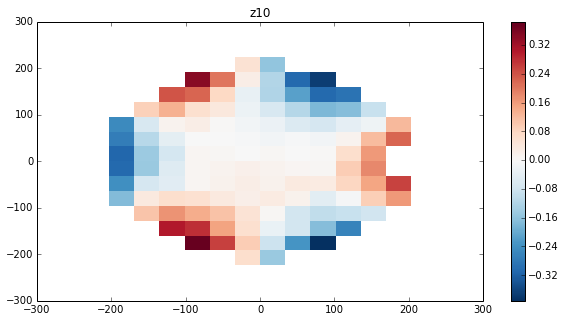

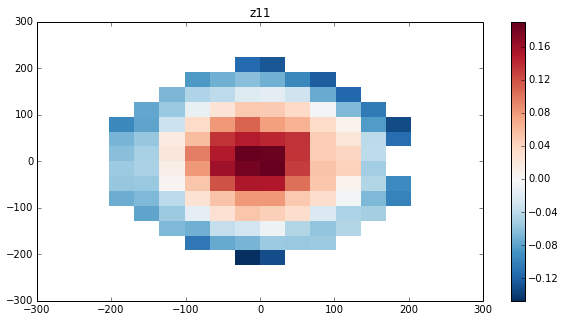

In [128]:
for i in xrange(4, 12):
    zkey = 'z{0}'.format(i)
    _ = WF.plot_colormap(psf_eval, 'x', 'y', zkey, num_bins=1)
    plt.title(zkey)

In [150]:
# interpolate moment guesses
psf_interpolated = moment_interpolator(data)
keys = [key for key in psf_eval if key in psf_interpolated]

psf_diff = ((psf_eval[keys] - psf_interpolated[keys]))# - (psf_eval[keys].mean() - psf_interpolated[keys].mean())) / (psf_eval[keys] - psf_eval[keys].mean())
for key in psf_diff.keys():
    psf_diff['eval_{0}'.format(key)] = psf_eval[key]
    psf_diff['interp_{0}'.format(key)] = psf_interpolated[key]
psf_diff['x'] = psf_eval['x']
psf_diff['y'] = psf_eval['y']
psf_diff['rzero'] = psf_eval['rzero']
psf_diff['ext'] = psf_eval['ext']


array([[<matplotlib.axes.AxesSubplot object at 0x11139a4d0>,
        <matplotlib.axes.AxesSubplot object at 0x1160ca7d0>]], dtype=object)

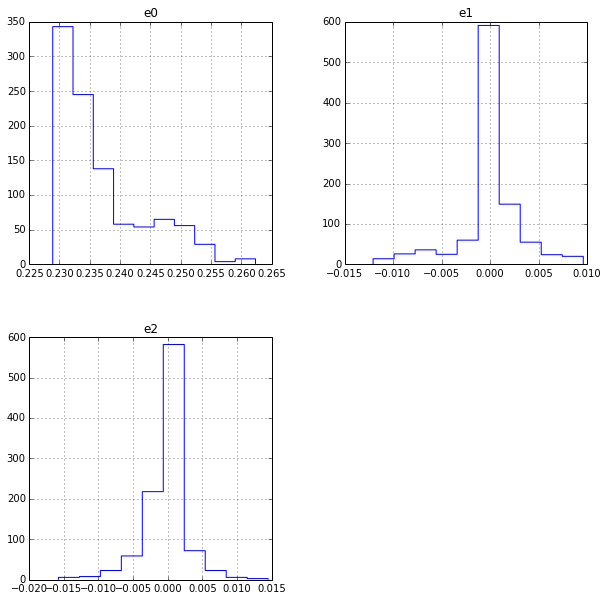

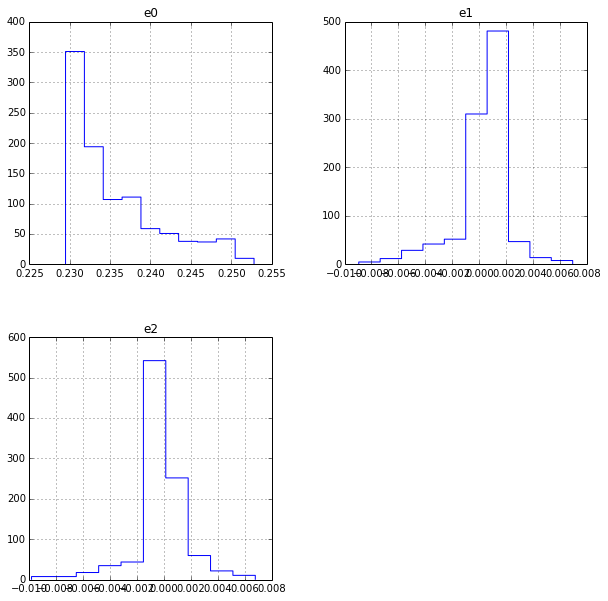

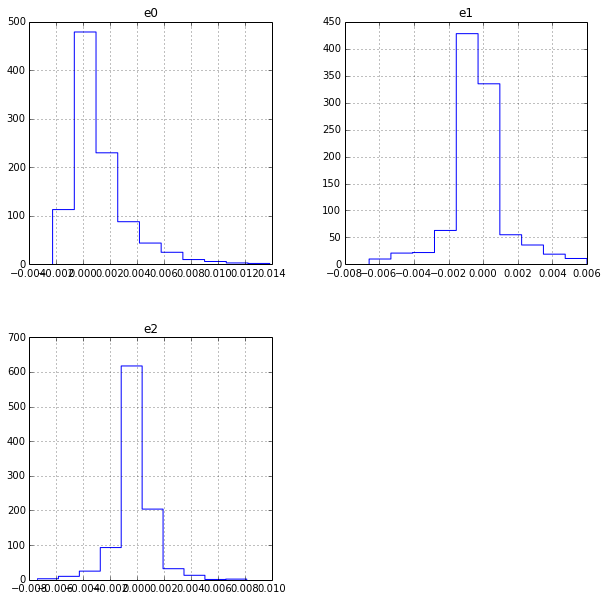

In [147]:
# plot each
psf_eval[['e0', 'e1', 'e2']].hist(bins=10, figsize=(10,10), histtype='step')
psf_interpolated[['e0', 'e1', 'e2']].hist(bins=10, figsize=(10,10), histtype='step')
psf_diff[['e0', 'e1', 'e2']].hist(bins=10, figsize=(10,10), histtype='step')

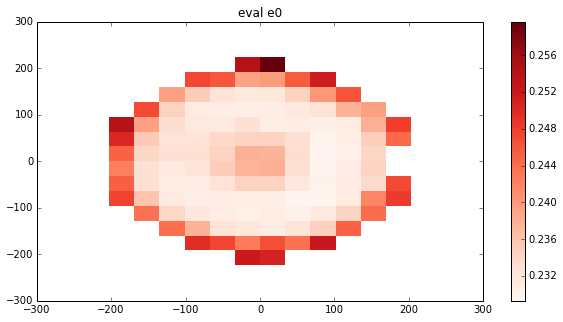

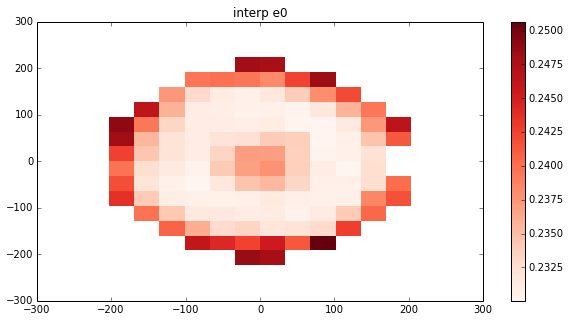

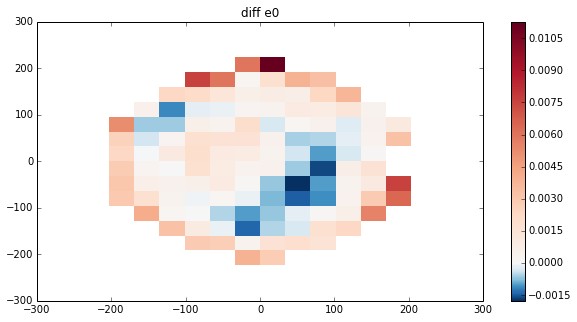

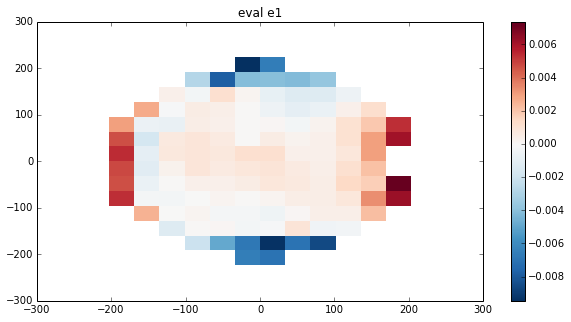

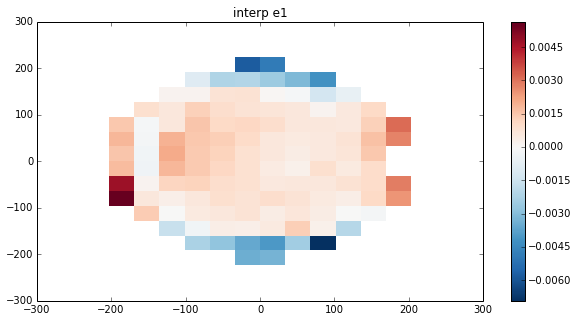

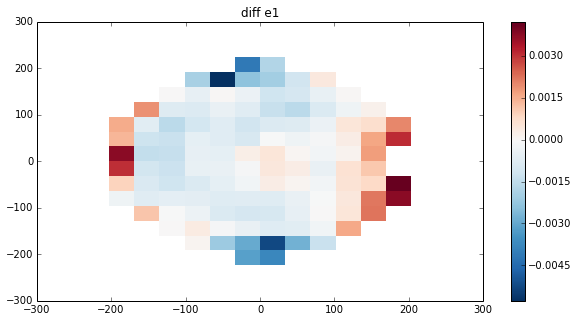

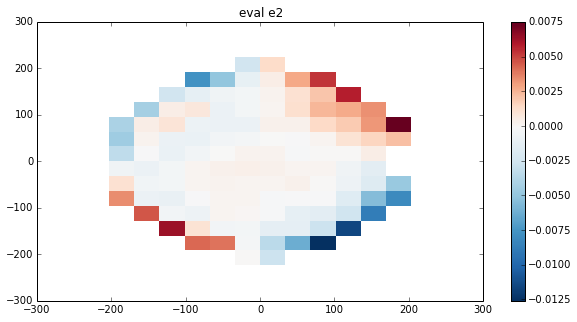

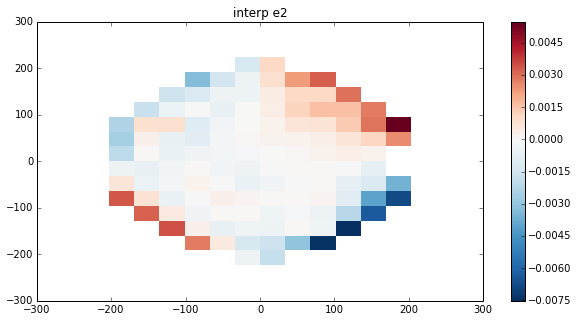

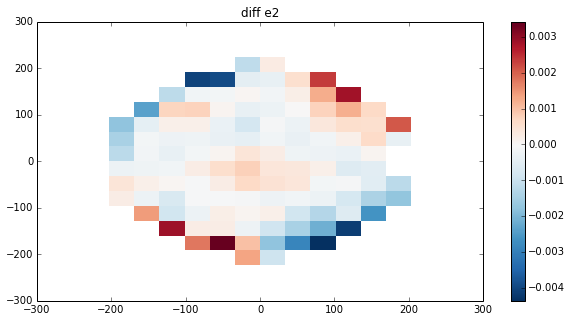

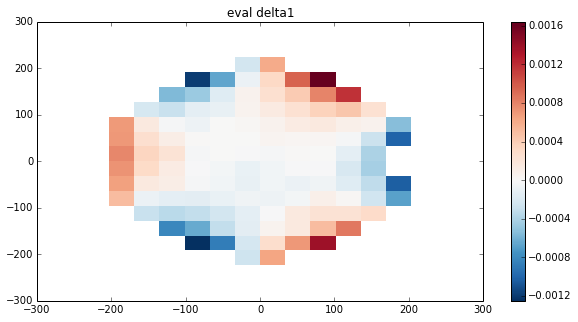

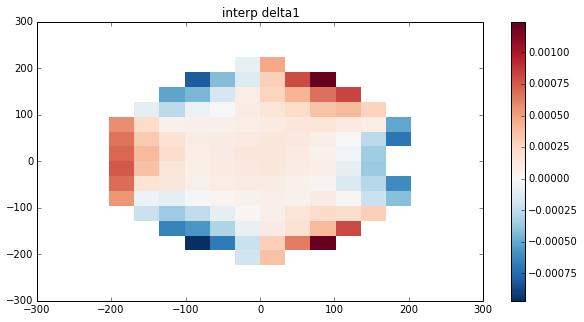

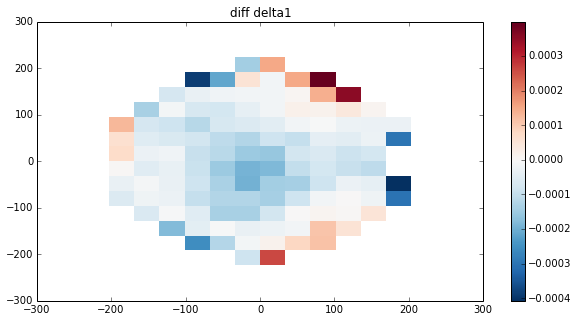

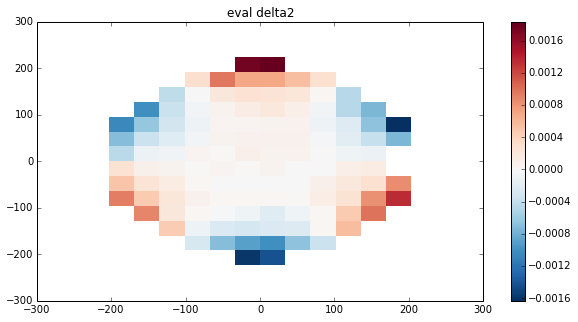

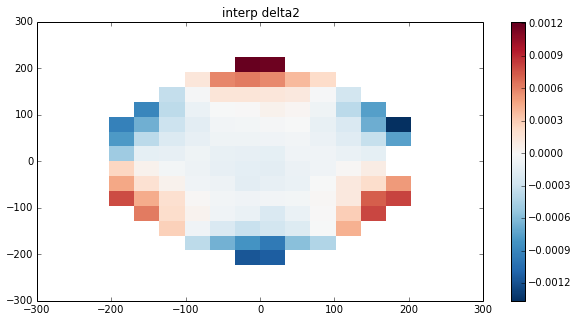

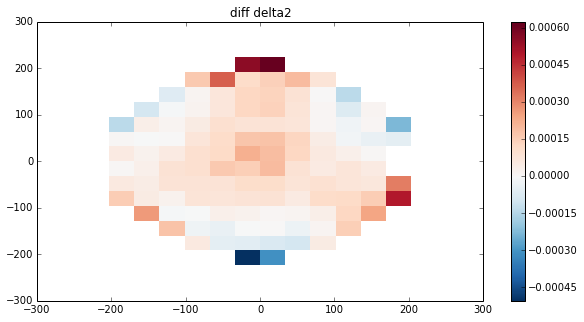

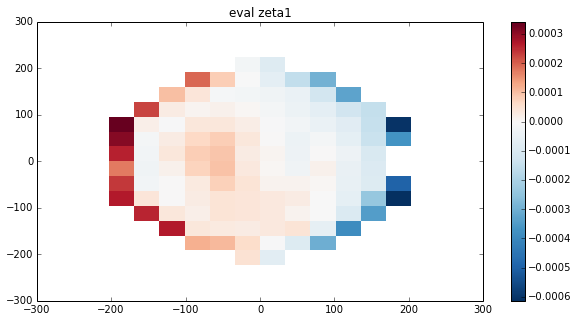

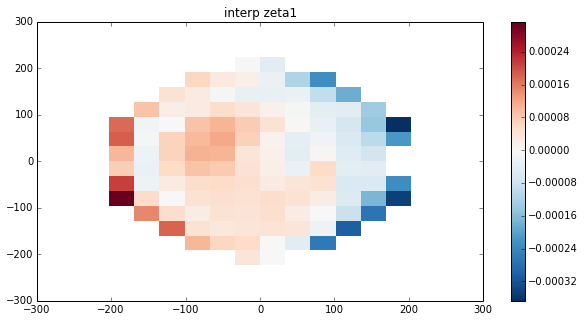

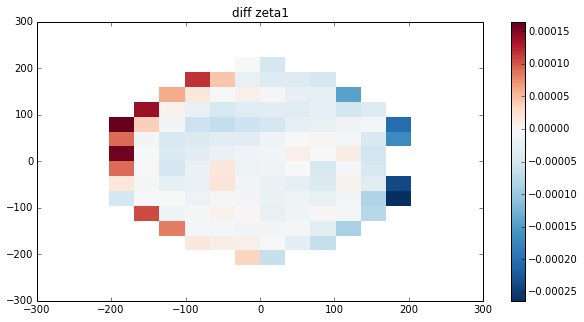

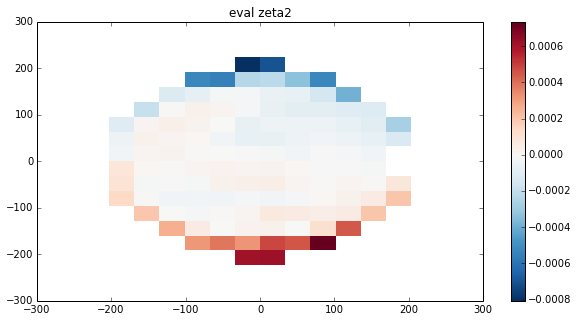

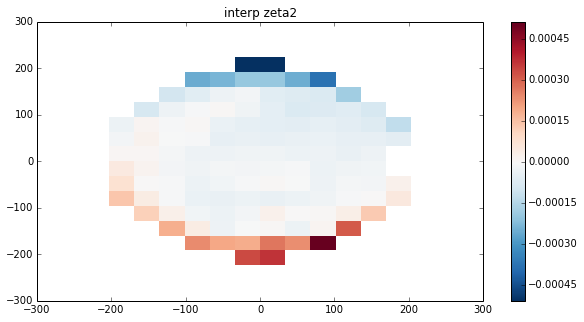

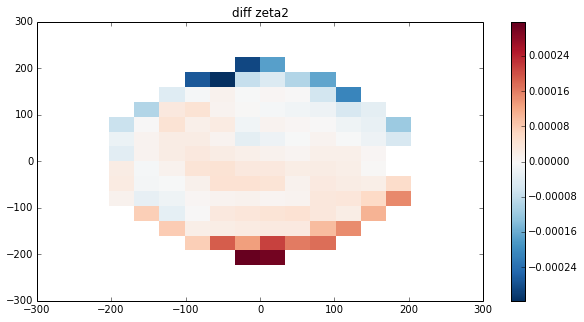

In [148]:
num_bins = 1
for key in ['e0', 'e1', 'e2', 'delta1', 'delta2', 'zeta1', 'zeta2']:
    fig, ax = WF.plot_colormap(psf_eval, 'x', 'y', key, num_bins=num_bins)
    ax.set_title('eval {0}'.format(key))
    fig, ax = WF.plot_colormap(psf_interpolated, 'x', 'y', key, num_bins=num_bins)
    ax.set_title('interp {0}'.format(key))
    fig, ax = WF.plot_colormap(psf_diff, 'x', 'y', key, num_bins=num_bins)
    ax.set_title('diff {0}'.format(key))

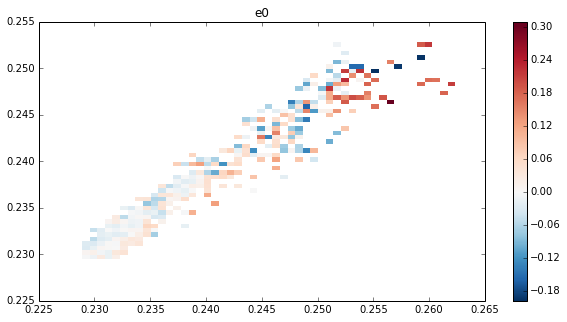

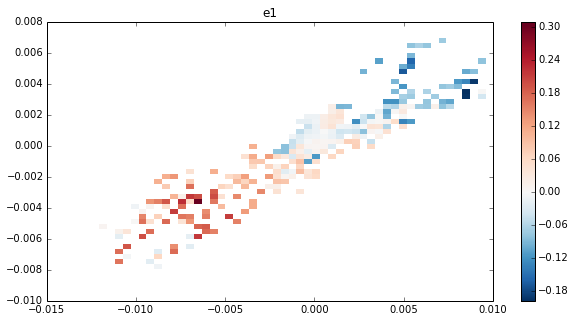

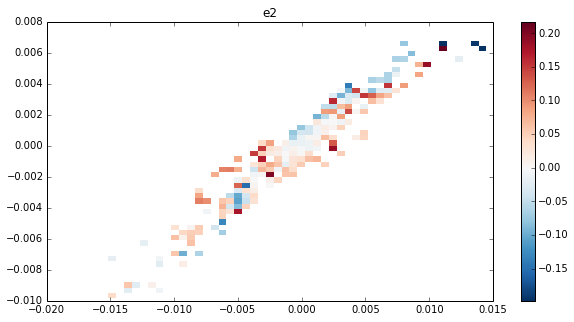

In [160]:
num_bins = 50
for key in ['e0', 'e1', 'e2']:#, 'delta1', 'delta2', 'zeta1', 'zeta2']:
    fig, ax = WF.plot_colormap(psf_diff, 'eval_{0}'.format(key), 'interp_{0}'.format(key), 'eval_z6', num_bins=num_bins)
    ax.set_title(key)

In [60]:
moment_data.columns

Index([u'Unnamed: 0.1', u'x', u'y', u'ccdnum', u'z4', u'w4', u'z5', u'w5', u'z6', u'w6', u'z7', u'w7', u'z8', u'w8', u'z9', u'w9', u'z10', u'w10', u'z11', u'w11', u'z1', u'z2', u'z3', u'rzero', u'e0', u'e1', u'e2', u'delta1', u'delta2', u'zeta1', u'zeta2', u'a4', u'flux', u'Mx', u'My', u'one_over_rzero'], dtype='object')

(<matplotlib.figure.Figure at 0x124592450>,
 <matplotlib.axes.AxesSubplot at 0x12b54ed90>)

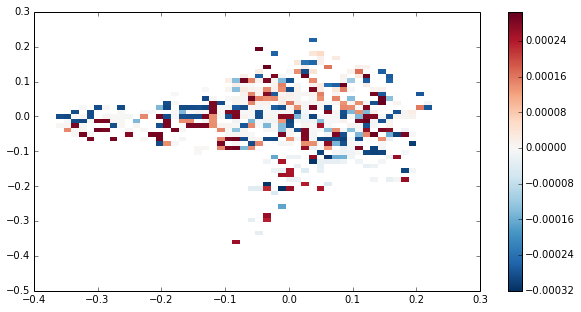

In [66]:
WF.plot_colormap(psf_eval, 'z4', 'z5', 'e2', num_bins=50)